# Day Trade Algortithm
## Toy Model Back-Testing

In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import scipy.stats as ss
from sklearn import linear_model
import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [2]:
print(xgb.__version__)
print(sklearn.__version__)
print(pd.__version__)
print(np.__version__)

2.1.3
1.6.0
2.2.3
2.0.2


In [3]:
# define daterange
start_date = datetime(2020,1,1)
end_date = datetime(2024,8,30)

# prepare features
feature = pd.read_csv('INFO6105_FeatureMart_with_meta_indicators.csv', index_col = [1])
feature['Date'] = pd.to_datetime(feature['Date'])
feature = feature.set_index('Date')

# fetch target variable (stock price or stock returns)
stock_symbol = 'META'
stock = yf.download(stock_symbol, start_date, end_date)
print(stock_symbol + ' Stock Price History')
print(stock.head())

# Correct the column names after merging
stock.columns = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']

# Reset the index before merging
stock.reset_index(inplace=True)
feature.reset_index(inplace=True)

# Perform the merge
data_frame = pd.merge(feature, stock, how='inner', on='Date')

# Handle missing values and reset the index
data_frame.fillna(method='ffill', inplace=True)
data_frame.reset_index(drop=True, inplace=True)


[*********************100%***********************]  1 of 1 completed

META Stock Price History
Price        Adj Close       Close        High         Low        Open  \
Ticker            META        META        META        META        META   
Date                                                                     
2020-01-02  209.150269  209.779999  209.789993  206.270004  206.750000   
2020-01-03  208.043610  208.669998  210.399994  206.949997  207.210007   
2020-01-06  211.961807  212.600006  212.779999  206.520004  206.699997   
2020-01-07  212.420410  213.059998  214.580002  211.750000  212.820007   
2020-01-08  214.573944  215.220001  216.240005  212.610001  213.000000   

Price         Volume  
Ticker          META  
Date                  
2020-01-02  12077100  
2020-01-03  11188400  
2020-01-06  17058900  
2020-01-07  14912400  
2020-01-08  13475000  



/var/folders/t9/95sv32551l196y_bgmpx2ywm0000gn/T/ipykernel_44000/701491432.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame.fillna(method='ffill', inplace=True)


In [4]:
# Remove the existing 'log_return' column if present
if 'log_return' in data_frame.columns:
    data_frame = data_frame.drop('log_return', axis=1)

# Calculate log return using the previous day's Close price
data_frame['log_return'] = np.log(data_frame['Close'] / data_frame['Close'].shift(1))

# Drop missing values created by the shift operation
data_frame.dropna(inplace=True)

# Verify the change by checking the first few rows
print(data_frame[['Open', 'Close', 'log_return']].head())


         Open       Close  log_return
1  208.043610  206.949997    0.003291
2  211.961807  206.520004   -0.002080
3  212.420410  211.750000    0.025009
4  214.573944  212.610001    0.004053
5  217.644699  216.279999    0.017114


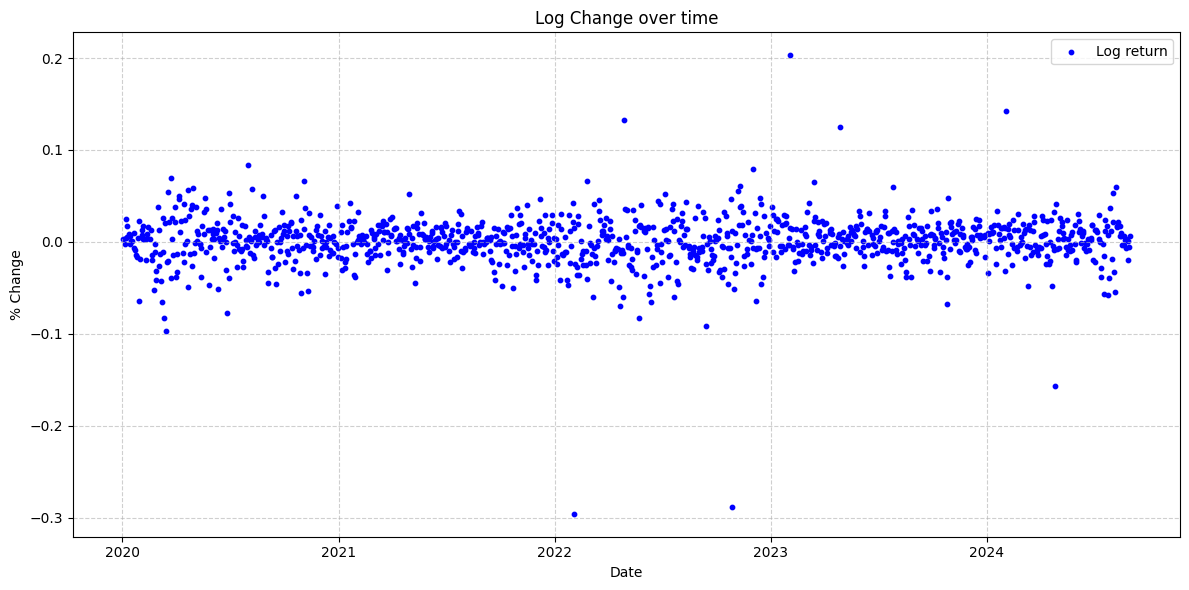

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(data_frame['Date'], data_frame['log_return'], label='Log return', color='blue', s=10)
plt.title('Log Change over time')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [6]:
data_frame

,Date,SMB,HML,RMW,CMA,RF,ADS_Index,SP500,T10Y3M,DGS10,...,SMA50,OBV,Kalman,Open,High,Low,Close,Adj_Close,Volume,log_return
1,2020-01-03,0.30,0.00,-0.13,-0.11,0.006,-0.279830,3234.85,0.28,1.80,...,197.856799,346748200,208.664315,208.043610,208.669998,210.399994,206.949997,207.210007,11188400,0.003291
2,2020-01-06,-0.21,-0.55,-0.17,-0.26,0.006,-0.245228,3246.28,0.25,1.81,...,198.385800,363807100,211.614464,211.961807,212.600006,212.779999,206.520004,206.699997,17058900,-0.002080
3,2020-01-07,-0.03,-0.25,-0.13,-0.24,0.006,-0.234188,3237.18,0.29,1.83,...,198.919399,378719500,212.698019,212.420410,213.059998,214.580002,211.750000,212.820007,14912400,0.025009
4,2020-01-08,-0.16,-0.66,-0.16,-0.18,0.006,-0.223434,3253.05,0.33,1.87,...,199.465999,392194500,214.588468,214.573944,215.220001,216.240005,212.610001,213.000000,13475000,0.004053
5,2020-01-09,-0.71,-0.48,-0.14,0.04,0.006,-0.212961,3274.70,0.31,1.85,...,200.044000,404837300,217.370592,217.644699,218.300003,218.380005,216.279999,217.539993,12642800,0.017114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,2024-08-23,1.90,0.85,-0.48,0.68,0.022,-0.140090,5634.61,-1.44,3.81,...,502.936000,1245186000,529.064247,527.496765,528.000000,539.869995,525.059998,536.919983,11323900,-0.006701
1169,2024-08-26,0.33,0.17,0.13,-0.06,0.022,-0.162837,5616.84,-1.42,3.82,...,503.276400,1235602000,523.109327,520.623352,521.119995,528.000000,514.950012,527.599976,9584000,-0.019443
1170,2024-08-27,-0.90,0.02,0.27,0.23,0.022,-0.172439,5625.80,-1.40,3.83,...,503.575200,1229319300,520.103963,518.605225,519.099976,524.010010,515.309998,518.979980,6282700,0.000699
1171,2024-08-28,-0.22,1.14,0.55,-0.16,0.022,-0.183081,5592.18,-1.37,3.84,...,503.778200,1220213200,517.612380,516.287476,516.780029,521.090027,512.450012,517.669983,9106100,-0.005565


## Feature importance

## trainig

In [7]:
# model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=200,         # Increase for better learning
#     learning_rate=0.05,       # Lower learning rate
#     max_depth=3,
#     random_state = 42
# )

# For Ridge Regression
from sklearn.linear_model import Ridge
 
# For Random Forest
from sklearn.ensemble import RandomForestRegressor

# Step 7: Initialize the XGBoost model with tuned hyperparameters
model = xgb.XGBRegressor(learning_rate=0.05, max_depth=3, n_estimators=200, random_state=42)

In [8]:
# # For Ridge Regression
# from sklearn.linear_model import Ridge
 
# # For Random Forest
# from sklearn.ensemble import RandomForestRegressor
 
# # # Ridge Regression model
# # model = Ridge(alpha=1.0, random_state=42)
 
# # # Random Forest model
# # model = RandomForestRegressor(n_estimators=200, max_depth=3, random_state=42)
 
 
# # XGBoost model
# # model = xgb.XGBRegressor(learning_rate=0.05, max_depth=3, n_estimators=200, random_state=42)

## log return as target model

In [9]:
features = ['RSI','RF','CMA','HML','Volatility','VIXCLS','RMW','SMB','DHHNGSP','EMVELECTGOVRN_interp']

## old log code

In [10]:
# Assuming the necessary features are defined

target = 'log_return'

# Assuming data_frame is already loaded
# data_frame['log_return'] = np.log(data_frame['Close'] / data_frame['Open'])

# Drop rows with missing values
data_frame = data_frame.dropna()

# Split the data into features and target variable
X = data_frame[features]
y = data_frame[target]

# Train-test split
train_size = int(0.90 * len(data_frame))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize and train the XGBoost model
model.fit(X_train, y_train)

# Trading simulation setup
start_date_index = 252
initial_balance = 50000
balance = {start_date_index: initial_balance}
position = 100
signal = {}
gain_loss = {}

# Define stop-loss, take-profit, and confidence threshold levels
stop_loss = 0.01  # 1% stop-loss
take_profit = 0.05  # 5% take-profit
confidence_threshold = 0.01  # Confidence threshold for making trades
threshold = 0.005  # Prediction threshold for buy/sell signal

# Trading loop
for today in range(start_date_index, len(data_frame) - 1):
    try:
        # Prepare test data for prediction
        X_test_today = data_frame.iloc[today:today + 1][features]

        # Predict the log return for tomorrow
        y_pred_tomorrow = model.predict(X_test_today)[0]  # Added [0] to get scalar value

        # Confidence check before trading
        if abs(y_pred_tomorrow) > confidence_threshold:
            if y_pred_tomorrow > threshold:
                signal[today + 1] = 1  # Buy signal
                trade_gain_loss = (data_frame['Close'].iloc[today + 1] - data_frame['Open'].iloc[today + 1]) * position

                # Implement stop-loss and take-profit check
                if (data_frame['Close'].iloc[today + 1] - data_frame['Open'].iloc[today + 1]) / data_frame['Open'].iloc[today + 1] < -stop_loss:
                    trade_gain_loss = -stop_loss * position  # Stop-loss triggered
                elif (data_frame['Close'].iloc[today + 1] - data_frame['Open'].iloc[today + 1]) / data_frame['Open'].iloc[today + 1] > take_profit:
                    trade_gain_loss = take_profit * position  # Take-profit triggered

            elif y_pred_tomorrow < -threshold:
                signal[today + 1] = -1  # Sell signal
                trade_gain_loss = (data_frame['Open'].iloc[today + 1] - data_frame['Close'].iloc[today + 1]) * position

        # Update balance (only if no error occurs)
        prev_balance = balance[today]  # Use direct indexing
        balance[today + 1] = prev_balance + trade_gain_loss
        gain_loss[today + 1] = trade_gain_loss

    except Exception as e:
        print(f"Error at index {today}: {e}")
        # Ensure balance remains the same if an error occurs
        if today in balance:
            balance[today + 1] = balance[today]

# Create results DataFrame
results = pd.DataFrame({
    'Signal': pd.Series(signal),
    'Gain/Loss': pd.Series(gain_loss),
    'Balance': pd.Series(balance)
})


Error at index 252: name 'trade_gain_loss' is not defined
Error at index 253: name 'trade_gain_loss' is not defined


In [11]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Print MAE and R² Score
print("MAE:", mean_absolute_error(y_test, model.predict(X_test)))
print("R² Score:", r2_score(y_test, model.predict(X_test)))

# Display all unique values in the 'Signal' column
unique_signals = results['Signal'].unique()
print("\nUnique Signals:", unique_signals)

# Display the frequency of each unique value in the 'Signal' column
signal_counts = results['Signal'].value_counts()
print("Signal Counts:", signal_counts)

# Collect predictions and actual values from the test set
predictions = []
actuals = []

# Re-run trading loop with prediction collection
for today in range(start_date_index, len(data_frame) - 1):
    try:
        # Prepare test data for prediction
        X_test_today = data_frame.iloc[today:today+1][features]

        # Predict the next day's percentage change
        y_pred_tomorrow = model.predict(X_test_today)[0]

        # Collect prediction and actual value
        predictions.append(y_pred_tomorrow)
        actuals.append(data_frame[target].iloc[today + 1])

    except Exception as e:
        print(f"Error at index {today}: {e}")

# Calculate MSE and then RMSE
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")



MAE: 0.01626049405116896
R² Score: 0.028775964993406622

Unique Signals: [nan -1.  1.]
Signal Counts: Signal
 1.0    143
-1.0    137
Name: count, dtype: int64
RMSE: 0.0307


In [12]:
print(y_pred_tomorrow)

0.0064226543


## old plot code

Strategy Total Return: $157,333.60
Buy & Hold Total Return: $46,161.34
Strategy Return Percentage: 314.67%
Buy & Hold Return Percentage: 92.32%


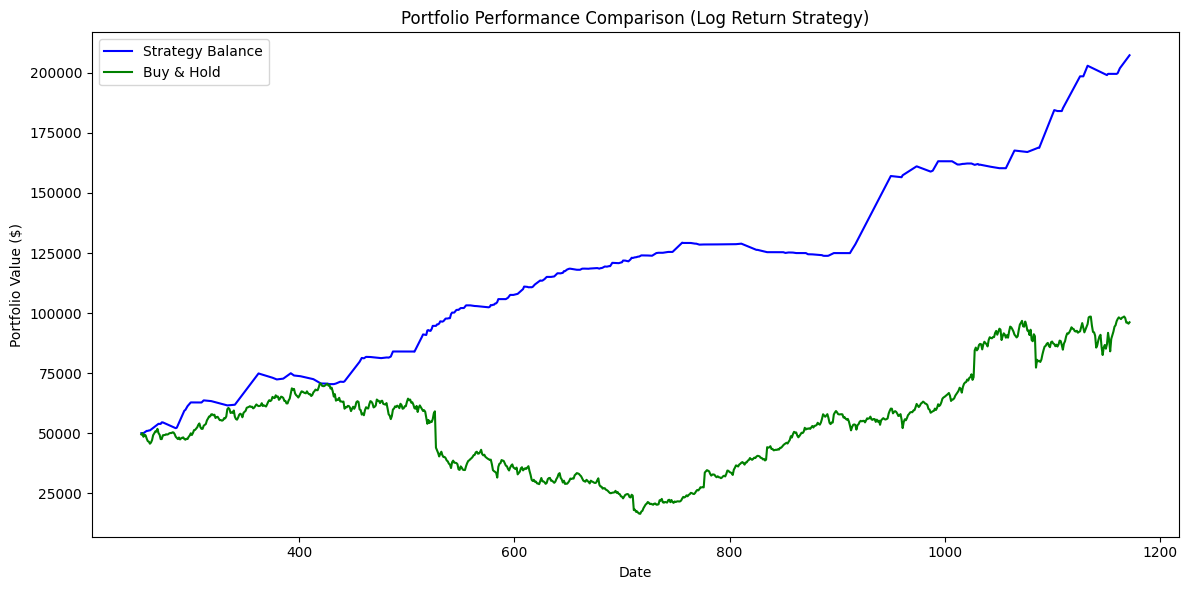

In [13]:
# Add the Date column using the stock index
results['Date'] = data_frame.index[results.index]
results.set_index('Date', inplace=True)

# --- Calculate Buy and Hold Strategy ---
initial_purchase_price = data_frame['Open'].iloc[start_date_index]
shares_purchased = initial_balance / initial_purchase_price

# Buy & Hold value over time
results['Buy_Hold'] = initial_balance + (
    data_frame['Close'].loc[results.index] - initial_purchase_price
) * shares_purchased

# --- Calculate Performance Metrics ---
results['Cumulative_Return'] = (results['Balance'] - initial_balance) / initial_balance * 100
results['Buy_Hold_Return'] = (results['Buy_Hold'] - initial_balance) / initial_balance * 100

# --- Performance Comparison ---
strategy_total_return = results['Balance'].iloc[-1] - initial_balance
buy_hold_return = results['Buy_Hold'].iloc[-1] - initial_balance

print(f"Strategy Total Return: ${strategy_total_return:,.2f}")
print(f"Buy & Hold Total Return: ${buy_hold_return:,.2f}")
print(f"Strategy Return Percentage: {strategy_total_return / initial_balance * 100:.2f}%")
print(f"Buy & Hold Return Percentage: {buy_hold_return / initial_balance * 100:.2f}%")

# --- Visualize Performance ---
plt.figure(figsize=(12,6))
plt.plot(results.index, results['Balance'], label='Strategy Balance', color='b')
plt.plot(results.index, results['Buy_Hold'], label='Buy & Hold', color='g')
plt.title('Portfolio Performance Comparison (Log Return Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.tight_layout()
plt.show()